# 05 — SQL ETL Pipeline

In this notebook, we demonstrate how SQL can be used for **ETL (Extract, Transform, Load)** operations on the Olist dataset.  

Instead of relying only on Python, we show how key joins, aggregations, and transformations can be executed in SQL, simulating a real database pipeline.  

**Objectives:**
- Load Olist tables into a relational database (SQLite).  
- Write SQL queries to replicate core transformations.  
- Extract the SQL outputs back into pandas for downstream analysis.  
- Illustrate SQL’s role in building scalable ETL pipelines.


In [1]:
import sqlite3
import pandas as pd
import os

# Assuming processed datasets are already available
base_path = "../data/processed/"

customers = pd.read_csv(os.path.join(base_path, "customers_cleaned.csv"))
orders = pd.read_csv(os.path.join(base_path, "orders_cleaned.csv"))
order_items = pd.read_csv(os.path.join(base_path, "order_items_cleaned.csv"))
products = pd.read_csv(os.path.join(base_path, "products_cleaned.csv"))
sellers = pd.read_csv(os.path.join(base_path, "sellers_cleaned.csv"))
payments = pd.read_csv(os.path.join(base_path, "payments_cleaned.csv"))
reviews = pd.read_csv(os.path.join(base_path, "reviews_cleaned.csv"))
categories = pd.read_csv(os.path.join(base_path, "categories_cleaned.csv"))

customers.head()


,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP


In [2]:
# Create local SQLite database
conn = sqlite3.connect("olist.db")

# Load tables into SQLite
customers.to_sql("customers", conn, if_exists="replace", index=False)
orders.to_sql("orders", conn, if_exists="replace", index=False)
order_items.to_sql("order_items", conn, if_exists="replace", index=False)
products.to_sql("products", conn, if_exists="replace", index=False)
sellers.to_sql("sellers", conn, if_exists="replace", index=False)
payments.to_sql("payments", conn, if_exists="replace", index=False)
reviews.to_sql("reviews", conn, if_exists="replace", index=False)
categories.to_sql("categories", conn, if_exists="replace", index=False)

print("✅ All tables successfully loaded into SQLite.")


✅ All tables successfully loaded into SQLite.


In [3]:
query = """
SELECT c.customer_id, c.customer_unique_id, o.order_id, o.order_status, o.order_purchase_timestamp
FROM customers c
JOIN orders o ON c.customer_id = o.customer_id
LIMIT 5;
"""
pd.read_sql(query, conn)


,customer_id,customer_unique_id,order_id,order_status,order_purchase_timestamp
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,00e7ee1b050b8499577073aeb2a297a1,delivered,2017-05-16 15:05:35
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,29150127e6685892b6eab3eec79f59c7,delivered,2018-01-12 20:48:24
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,b2059ed67ce144a36e2aa97d2c9e9ad2,delivered,2018-05-19 16:07:45
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,951670f92359f4fe4a63112aa7306eba,delivered,2018-03-13 16:06:38
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,6b7d50bd145f6fc7f33cebabd7e49d0f,delivered,2018-07-29 09:51:30


In [4]:
query = """
SELECT s.seller_id,
       SUM(oi.price + oi.freight_value) AS total_revenue,
       COUNT(DISTINCT oi.order_id) AS num_orders
FROM sellers s
JOIN order_items oi ON s.seller_id = oi.seller_id
GROUP BY s.seller_id
ORDER BY total_revenue DESC
LIMIT 10;
"""
seller_revenue_sql = pd.read_sql(query, conn)
seller_revenue_sql


,seller_id,total_revenue,num_orders
0,4869f7a5dfa277a7dca6462dcf3b52b2,249640.70,1132
1,7c67e1448b00f6e969d365cea6b010ab,239536.44,982
2,53243585a1d6dc2643021fd1853d8905,235856.68,358
3,4a3ca9315b744ce9f8e9374361493884,235539.96,1806
4,fa1c13f2614d7b5c4749cbc52fecda94,204084.73,585
5,da8622b14eb17ae2831f4ac5b9dab84a,185192.32,1314
6,7e93a43ef30c4f03f38b393420bc753a,182754.05,336
7,1025f0e2d44d7041d6cf58b6550e0bfa,172860.69,915
8,7a67c85e85bb2ce8582c35f2203ad736,162648.38,1160
9,955fee9216a65b617aa5c0531780ce60,160602.68,1287


In [5]:
query = """
SELECT p.product_category_name,
       COUNT(oi.order_id) AS total_sales
FROM products p
JOIN order_items oi ON p.product_id = oi.product_id
GROUP BY p.product_category_name
ORDER BY total_sales DESC
LIMIT 10;
"""
popular_categories_sql = pd.read_sql(query, conn)
popular_categories_sql


,product_category_name,total_sales
0,cama_mesa_banho,11115
1,beleza_saude,9670
2,esporte_lazer,8641
3,moveis_decoracao,8334
4,informatica_acessorios,7827
5,utilidades_domesticas,6964
6,relogios_presentes,5991
7,telefonia,4545
8,ferramentas_jardim,4347
9,automotivo,4235


In [6]:
query = """
SELECT c.customer_unique_id,
       SUM(pay.payment_value) AS lifetime_value
FROM customers c
JOIN orders o ON c.customer_id = o.customer_id
JOIN payments pay ON o.order_id = pay.order_id
GROUP BY c.customer_unique_id
ORDER BY lifetime_value DESC
LIMIT 10;
"""
customer_ltv_sql = pd.read_sql(query, conn)
customer_ltv_sql


,customer_unique_id,lifetime_value
0,0a0a92112bd4c708ca5fde585afaa872,13664.08
1,46450c74a0d8c5ca9395da1daac6c120,9553.02
2,da122df9eeddfedc1dc1f5349a1a690c,7571.63
3,763c8b1c9c68a0229c42c9fc6f662b93,7274.88
4,dc4802a71eae9be1dd28f5d788ceb526,6929.31
5,459bef486812aa25204be022145caa62,6922.21
6,ff4159b92c40ebe40454e3e6a7c35ed6,6726.66
7,4007669dec559734d6f53e029e360987,6081.54
8,5d0a2980b292d049061542014e8960bf,4809.44
9,eebb5dda148d3893cdaf5b5ca3040ccb,4764.34


In [7]:
output_path = "../data/interim/"

seller_revenue_sql.to_csv(os.path.join(output_path, "seller_revenue_sql.csv"), index=False)
popular_categories_sql.to_csv(os.path.join(output_path, "popular_categories_sql.csv"), index=False)
customer_ltv_sql.to_csv(os.path.join(output_path, "customer_ltv_sql.csv"), index=False)

print("✅ SQL ETL outputs saved into data/interim/")


✅ SQL ETL outputs saved into data/interim/


# ✅ Summary — SQL ETL

In this notebook, we successfully demonstrated how SQL can be integrated into the Olist project:

- **Extracted**: Loaded cleaned datasets into a relational database (SQLite).  
- **Transformed**: Ran SQL queries to compute seller revenue, product category sales, and customer lifetime value.  
- **Loaded**: Exported SQL query results back into the pipeline (`/data/interim/`).  

This shows how **SQL complements Python**:  
- SQL excels at joins and aggregations in a scalable, declarative way.  
- Python is then used for visualization and advanced analytics.  

By including SQL ETL, this project illustrates **end-to-end data engineering and analysis skills**, bridging databases with Python workflows.


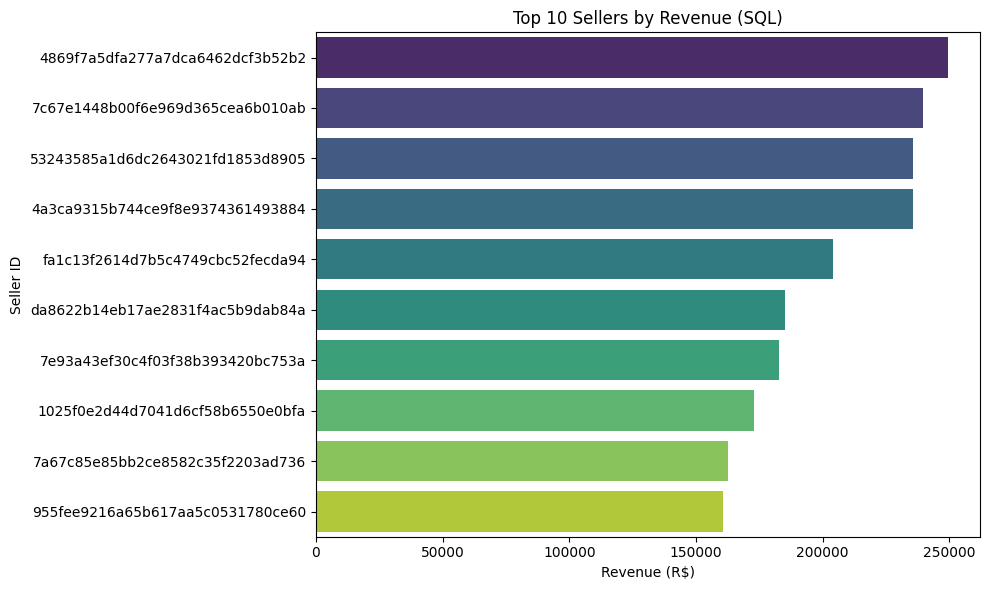

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
sns.barplot(
    y="seller_id",
    x="total_revenue",
    data=seller_revenue_sql,
    hue="seller_id", legend=False, palette="viridis"
)
plt.title("Top 10 Sellers by Revenue (SQL)")
plt.xlabel("Revenue (R$)")
plt.ylabel("Seller ID")
plt.tight_layout()
plt.show()


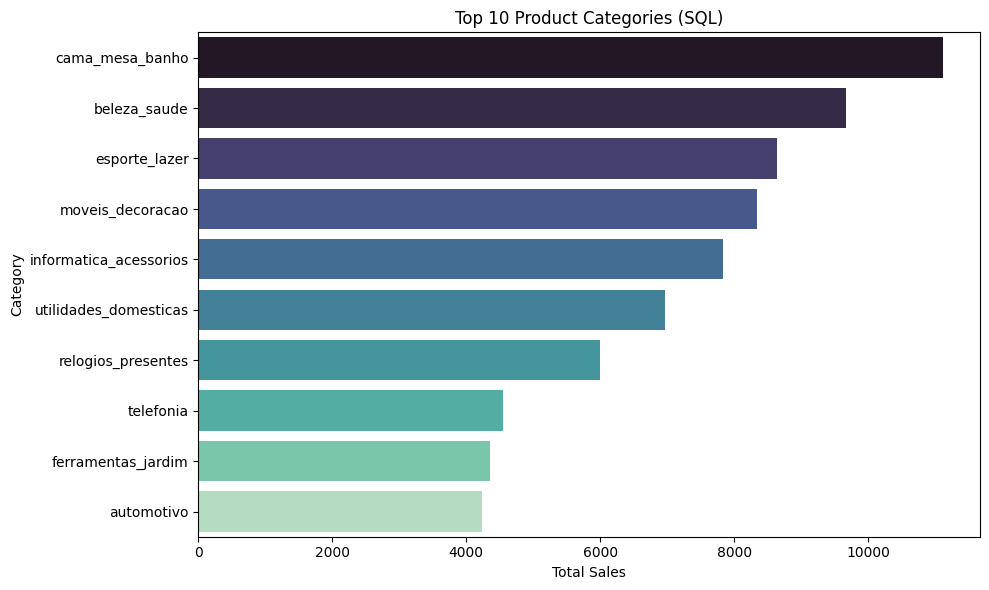

In [9]:
plt.figure(figsize=(10,6))
sns.barplot(
    y="product_category_name",
    x="total_sales",
    data=popular_categories_sql,
    hue="product_category_name", legend=False, palette="mako"
)
plt.title("Top 10 Product Categories (SQL)")
plt.xlabel("Total Sales")
plt.ylabel("Category")
plt.tight_layout()
plt.show()


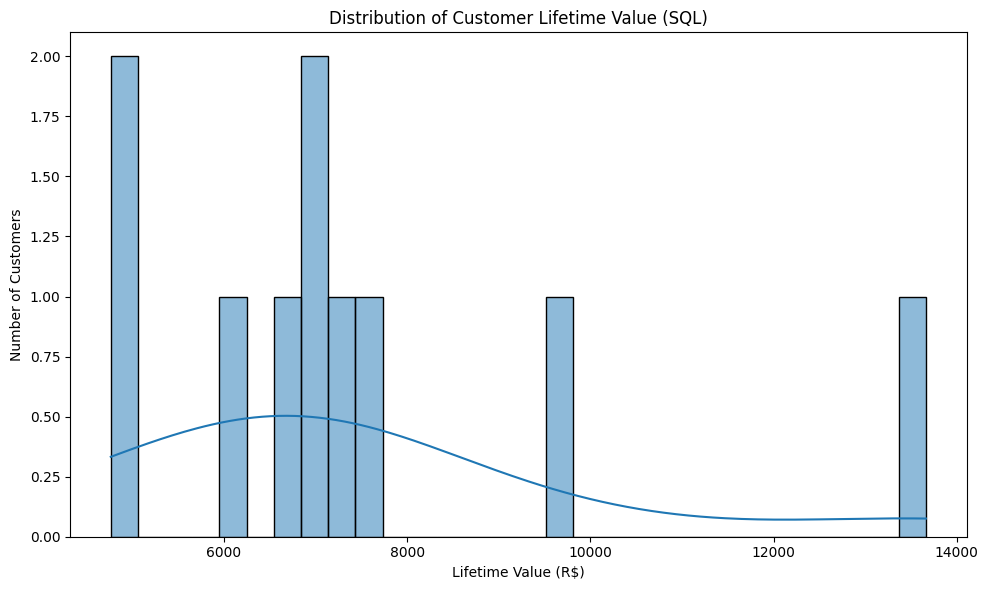

In [10]:
plt.figure(figsize=(10,6))
sns.histplot(customer_ltv_sql["lifetime_value"], bins=30, kde=True)
plt.title("Distribution of Customer Lifetime Value (SQL)")
plt.xlabel("Lifetime Value (R$)")
plt.ylabel("Number of Customers")
plt.tight_layout()
plt.show()


# 🎯 Final Thoughts

With the addition of visualizations:
- **Sellers**: We can quickly identify the top-performing sellers by revenue.  
- **Products**: Popular categories emerge clearly, useful for marketing or inventory strategy.  
- **Customers**: LTV distribution shows inequality among customers — most spend modestly, while a few contribute disproportionately.  

👉 This demonstrates the **end-to-end analyst workflow**:  
SQL for **data extraction & transformation**, then Python for **visual storytelling**.  
